# Part 1: Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from string import punctuation
from datetime import datetime
import re

In [2]:
subway = pd.read_csv("subway-data.csv")
subway.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2024/01/01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491
1,2024/01/01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0
2,2024/01/01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051
3,2024/01/01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284
4,2024/01/01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986


In [3]:
subway_ref = pd.read_csv("subway-delay-codes.csv")
subway_ref.head()

,Number,SUB RMENU CODE,CODE DESCRIPTION
0,1,EUAC,Air Conditioning
1,2,EUAL,Alternating Current
2,3,EUATC,ATC RC&S Equipment
3,4,EUBK,Brakes
4,5,EUBO,Body


In [4]:
subway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24122 entries, 0 to 24121
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       24122 non-null  object
 1   Time       24122 non-null  object
 2   Day        24122 non-null  object
 3   Station    24122 non-null  object
 4   Code       24122 non-null  object
 5   Min Delay  24122 non-null  int64 
 6   Min Gap    24122 non-null  int64 
 7   Bound      15508 non-null  object
 8   Line       24089 non-null  object
 9   Vehicle    24122 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 1.8+ MB


In [5]:
subway_ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Number            129 non-null    int64 
 1   SUB RMENU CODE    129 non-null    object
 2   CODE DESCRIPTION  129 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.2+ KB


In [6]:
# Convert 'Date' to datetime format
subway['Date'] = pd.to_datetime(subway['Date'])

# Split 'Date' to Date, Month, Year
subway['Year'] = subway['Date'].dt.year
subway['Month'] = subway['Date'].dt.month
subway['ExactDate'] = subway['Date'].dt.day

# Ensure 'Time' column is in datetime format
subway['Time'] = pd.to_datetime(subway['Time'], format='%H:%M')

# Extract the hour
subway['Hour'] = subway['Time'].dt.hour

# Remove non-delays
# subway = subway[subway['Min Delay'] > 0]

# Define delay categories
bins = [0, 10, 40, np.inf]  # Ranges: <10, 10-40, >40
labels = ["Small", "Moderate", "Severe"]

# Create the 'Delay Level' column
subway['Delay Level'] = pd.cut(subway['Min Delay'], bins=bins, labels=labels, right=True)


# Drop null delay values
subway = subway[subway['Min Delay'].notna()]

# Rename columns in subway_ref for merging
subway_ref.rename(columns={'SUB RMENU CODE': 'Code', 'CODE DESCRIPTION': 'Incident'}, inplace=True)

# Merge subway with subway_ref on 'Code'
subway = subway.merge(subway_ref[['Code', 'Incident']], on='Code', how='left')

# Fill missing values in 'Incident' with 'Unknown'
subway['Incident'] = subway['Incident'].fillna('Unknown')

In [7]:
subway.isnull().sum()

Date               0
Time               0
Day                0
Station            0
Code               0
Min Delay          0
Min Gap            0
Bound           8614
Line              33
Vehicle            0
Year               0
Month              0
ExactDate          0
Hour               0
Delay Level    15543
Incident           0
dtype: int64

In [8]:
subway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24122 entries, 0 to 24121
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         24122 non-null  datetime64[ns]
 1   Time         24122 non-null  datetime64[ns]
 2   Day          24122 non-null  object        
 3   Station      24122 non-null  object        
 4   Code         24122 non-null  object        
 5   Min Delay    24122 non-null  int64         
 6   Min Gap      24122 non-null  int64         
 7   Bound        15508 non-null  object        
 8   Line         24089 non-null  object        
 9   Vehicle      24122 non-null  int64         
 10  Year         24122 non-null  int32         
 11  Month        24122 non-null  int32         
 12  ExactDate    24122 non-null  int32         
 13  Hour         24122 non-null  int32         
 14  Delay Level  8579 non-null   category      
 15  Incident     24122 non-null  object        
dtypes: c

In [9]:
def line_simplifier(line):
    line = str(line).upper().replace(rf'[{punctuation}]', '').strip()
    if 'YU  BD' in line or 'YUBD' in line or 'YU BD' in line or 'BDYU' in line:
        return 'YU-BD'
    elif 'BD' in line or 'BLOOR DANFORTH LINE' in line or 'BLOOR DANFORTH LINES' in line or 'BLOORDANFORTH' in line:
        return 'BD'
    elif 'YU' in line or 'YU LINE' in line :
        return 'YU'
    elif 'SRT' in line:
        return 'SRT'
    elif 'SHP' in line or 'SHEPPARD' in line:
        return 'SHP'
    else:
        'NaN'

subway['Line'] = subway['Line'].apply(line_simplifier)
subway.Line = subway.Line.replace({'YU-BD':np.nan})
subway['Line'].value_counts()

Line
YU     12929
BD     10340
SHP      812
SRT        2
Name: count, dtype: int64

In [10]:
station_mapping = {
    'SHEPPARD STATION': 'SHEPPARD', 'DUNDAS STATION': 'DUNDAS', 'KENNEDY BD STATION': 'KENNEDY',
    'BLOOR STATION': 'BLOOR-YONGE', 'ST CLAIR STATION': 'ST CLAIR', 'WOODBINE STATION': 'WOODBINE',
    'FINCH STATION': 'FINCH', 'DAVISVILLE STATION': 'DAVISVILLE', 'COLLEGE STATION': 'COLLEGE',
    'LAWRENCE WEST STATION': 'LAWRENCE WEST', 'VICTORIA PARK STATION': 'VICTORIA PARK',
    'NORTH YORK CTR STATION': 'NORTH YORK CENTRE', 'KIPLING STATION': 'KIPLING', 'DUPONT STATION': 'DUPONT',
    'SHEPPARD WEST STATION': 'SHEPPARD WEST', 'EGLINTON STATION': 'EGLINTON', 'SUMMERHILL STATION': 'SUMMERHILL',
    'QUEEN STATION': 'QUEEN', 'OLD MILL STATION': 'OLD MILL', 'SPADINA YUS STATION': 'SPADINA',
    'ST PATRICK STATION': 'ST PATRICK', 'VAUGHAN MC STATION': 'VAUGHAN METROPOLITAN CENTRE', 'YONGE BD STATION': 'YONGE',
    'LANSDOWNE STATION': 'LANSDOWNE', 'ST GEORGE YUS STATION': 'ST GEORGE', 'SPADINA BD STATION': 'SPADINA',
    'ROSEDALE STATION': 'ROSEDALE', 'DUFFERIN STATION': 'DUFFERIN', 'DONLANDS STATION': 'DONLANDS',
    'YONGE-UNIVERSITY AND B': 'UNKNOWN', 'GO PROTOCOL - DANFORTH': 'UNKNOWN',
    'WARDEN STATION': 'WARDEN', 'ST CLAIR WEST STATION': 'ST CLAIR WEST', 'CHRISTIE STATION': 'CHRISTIE',
    'BROADVIEW STATION': 'BROADVIEW', 'BAY STATION': 'BAY', 'FINCH WEST STATION': 'FINCH WEST',
    'CHESTER STATION': 'CHESTER', "QUEEN'S PARK STATION": "QUEEN'S PARK",
    'DOWNSVIEW PARK STATION': 'DOWNSVIEW PARK', 'KEELE STATION': 'KEELE', 'WELLESLEY STATION': 'WELLESLEY',
    'MUSEUM STATION': 'MUSEUM', 'ISLINGTON STATION': 'ISLINGTON', 'PIONEER VILLAGE STATIO': 'PIONEER VILLAGE',
    'MAIN STREET STATION': 'MAIN STREET', 'SHERBOURNE STATION': 'SHERBOURNE',
    'ST GEORGE BD STATION': 'ST GEORGE', 'YORKDALE STATION': 'YORKDALE', 'DUNDAS WEST STATION': 'DUNDAS WEST',
    'GREENWOOD YARD': 'GREENWOOD', 'EGLINTON WEST STATION': 'EGLINTON WEST', 'JANE STATION': 'JANE',
    'SHEPPARD-YONGE STATION': 'SHEPPARD-YONGE', 'DON MILLS STATION': 'DON MILLS', 'BAYVIEW STATION': 'BAYVIEW',
    'UNION STATION': 'UNION', 'BATHURST STATION': 'BATHURST', 'LAWRENCE STATION': 'LAWRENCE',
    'COXWELL STATION': 'COXWELL', 'OSGOODE STATION': 'OSGOODE', 'OSSINGTON STATION': 'OSSINGTON',
    'WILSON STATION': 'WILSON', 'BESSARION STATION': 'BESSARION', 'ROYAL YORK STATION': 'ROYAL YORK',
    'DAVISVILLE YARD': 'DAVISVILLE', 'YORK UNIVERSITY STATIO': 'YORK UNIVERSITY', 'YORK MILLS STATION': 'YORK MILLS',
    'HIGH PARK STATION': 'HIGH PARK', 'ST ANDREW STATION': 'ST ANDREW', 'UNION AND DOWNSVIEW': 'UNION',
    'GREENWOOD STATION': 'GREENWOOD', 'KING STATION': 'KING', 'SPADINA STATION': 'SPADINA',
    'PAPE STATION': 'PAPE', 'GLENCAIRN STATION': 'GLENCAIRN', 'CASTLE FRANK STATION': 'CASTLE FRANK',
    'HIGHWAY 407 STATION': 'HIGHWAY 407', 'BLOOR DANFORTH SUBWAY': 'UNKNOWN', 'LESLIE STATION': 'LESLIE',
    'EGLINTON STATION (SOUT': 'EGLINTON', 'RUNNYMEDE STATION': 'RUNNYMEDE',
    'DAVISVILLE TO EGLINTON': 'DAVISVILLE', 'YONGE - UNIVERSITY AND': 'UNKNOWN',
    'SUBWAY CLOSURE: WEEKEN': 'UNKNOWN', 'KIPLING TO UNION STATI': 'KIPLING', 
    'EGLINTON TO YORK MILLS': 'EGLINTON', 'TORONTO TRANSIT COMMIS': 'UNKNOWN',
    'DUNDAS STATION W/S': 'DUNDAS', 'EGLINTON STATION TO YO': 'EGLINTON',  
    'UNKNOWN LOCATION': 'UNKNOWN',  
    'DUNDAS STATION TO EGLI': 'DUNDAS',  
    'SUBWAY CLOSURE: ST GEO': 'ST GEORGE',  
    'DOWNVIEW PARK STN - UN': 'DOWNSVIEW PARK',  
    'HIGHWAY 407 STATION TO': 'HIGHWAY 407',  
    'YONGE / UNIVERSITY LIN': 'UNKNOWN',  
    'LANSDOWNE TO ROYAL YOR': 'LANSDOWNE',  
    'OSSINGTON TO PAPE': 'OSSINGTON',  
    'KIPLING STATION TO JAN': 'KIPLING',  
    'FINCH WEST CENTER TRAC': 'FINCH WEST',  
    'LINE 1 SUBWAY CLOSURE': 'UNKNOWN',  
    'BAY LOWER': 'BAY',  
    'SUBWAY CLOSURE: LAWREN': 'LAWRENCE',  
    'ST GEORGE TO PAPE': 'ST GEORGE',  
    'DAVISVILLE BUILD UP': 'DAVISVILLE',  
    'EARLY CLOSURE KING TO': 'KING',  
    'UNION TO KING STATIONS': 'UNION',  
    'ST GEORGE STATION': 'ST GEORGE',  
    'SPADINA TO KING': 'SPADINA',  
    'UNION STATION TO ST AN': 'UNION',  
    'UNION STATION TO FINCH': 'UNION',  
    'YONGE- UNIVERSITY AND': 'UNKNOWN',  
    'SUBWAY CLOSURE: WARDEN': 'WARDEN',  
    'YONGE-UNIVERSITY LINE': 'UNKNOWN',  
    'BLOOR DANFORTH LINE': 'UNKNOWN',  
    'SUBWAY CLOSURE BLOOR-D': 'UNKNOWN',  
    'MILL STREET EMERGENCY': 'UNKNOWN',  
    'YONGE UNIVERSITY LINE': 'UNKNOWN',  
    'KING STATION TO SPADIN': 'KING',  
    'OSGOODE POCKET': 'OSGOODE',  
    'UNION STATION--ST ANDR': 'UNION',  
    'WILSON YARD': 'WILSON',  
    'EGLINTON TO FINCH': 'EGLINTON',  
    'NORTH YORK CTR TO ST A': 'NORTH YORK CENTRE',  
    'YONGE-UNIVERSITY SUBWA': 'UNKNOWN',  
    'DAVISVILLE BUILD-UP': 'DAVISVILLE',  
    'DUFFERIN TO KIPLING': 'DUFFERIN',  
    'UNION STATION HUB': 'UNION',
    'YONGE/UNIVERSITY AND B': 'UNKNOWN',  
    'LINE 2 BLOOR DANFORTH': 'UNKNOWN',  
    'KING TO SPADINA': 'KING',  
    'DUNDAS TO FINCH': 'DUNDAS',  
    'BATHUST TO PAPE STATIO': 'BATHURST',  
    'GUNN BUILDING': 'UNKNOWN',  
    'UNION CENTRE TRACK': 'UNION',  
    'LEONA EE': 'UNKNOWN',  
    'UNION TO FINCH STATION': 'UNION',  
    'CHRISTIE TO PAPE STATI': 'CHRISTIE',  
    'KING STATION TO ST. CL': 'KING',  
    'CHRISTIE STATION TO PA': 'CHRISTIE',  
    'UNION STATION - HUB': 'UNION',  
    'ST CLAIR WEST TO KING': 'ST CLAIR WEST',  
    'CHANGE OVERS LINE TWO': 'UNKNOWN',  
    'WILSON YARD HOSTLER #2': 'WILSON',  
    'LINE 1 YUS': 'UNKNOWN',  
    'GREENWOOD TRACK AND ST': 'GREENWOOD',  
    'S/O TEDDINGTON TO S/O': 'UNKNOWN',  
    'DUNDAS TO FINCH STATIO': 'DUNDAS',  
    'MARKDALE EMERGENCY EXI': 'UNKNOWN',  
    'UNION STATION (TO ST.A': 'UNION',  
    'YORK MILLS AND EGLINTO': 'YORK MILLS',  
    'GREENWOOD PORTAL': 'GREENWOOD',  
    'KEELE YARD': 'KEELE',  
    'UNION STATION TO ST. A': 'UNION',  
    'YORK MILLS STATION TO': 'YORK MILLS',  
    'SHEPPARD WYE': 'SHEPPARD-YONGE',  
    'DAVISVILLE BUILDUP': 'DAVISVILLE',  
    'CHRSTIE TO PAPE STATIO': 'CHRISTIE',  
    'WARDEN TO KENNEDY': 'WARDEN',  
    'HIGH PARK - KEELE STAT': 'HIGH PARK',  
    'UNION TO BLOOR': 'UNION',  
    'GREENWOOD CARHOUSE': 'GREENWOOD',  
    'GREENWOOD COMPLEX': 'GREENWOOD',  
    'WILFRED EMERGENCY EXIT': 'UNKNOWN',  
    'EGLINTON TO UNION STAT': 'EGLINTON',  
    'COLLEGE AND OSGOODE ST': 'COLLEGE',  
    'BAY STATION TO PAPE ST': 'BAY',  
    'OSGOODE TO COLLEGE STA': 'OSGOODE',  
    'GREENWOOD WYE': 'GREENWOOD',  
    'YONGE STATION': 'BLOOR-YONGE',  
    'OSSINGTON TO CHESTER': 'OSSINGTON',  
    'OSSINGTON AND LANSDOWN': 'OSSINGTON',  
    'KIPLING STATION TO COX': 'KIPLING',  
    'CHRISTIE STATION (LEAV': 'CHRISTIE',  
    'QUEENS PARK STATION': "QUEEN'S PARK",  
    'EGLINTON TO UNION': 'EGLINTON',  
    'WILSON CARHOUSE': 'WILSON',  
    'DANFORTH DIVISION': 'UNKNOWN',  
    'ST GEORGE BD/YU STATIO': 'ST GEORGE',  
    'LESLIE STATION (APPROA': 'LESLIE',  
    'YORK MILLS STATION - C': 'YORK MILLS',  
    'UNION STATION (TOWARDS': 'UNION',  
    'UNION STATION (TO KING': 'UNION',  
    'YOUNG UNIVERSITY LINE': 'UNKNOWN',  
    'UNION STATION TO KING': 'UNION',  
    'EGLINTON TO COLLEGE': 'EGLINTON',  
    'UNION STATION (TOWARD': 'UNION',  
    'WARDEN TO VICTORIA PAR': 'WARDEN',  
    'CHRISTIE STATION TO CH': 'CHRISTIE',  
    'YONGE AND SHEPPARD': 'SHEPPARD-YONGE',  
    'OLD MILLS STATION': 'OLD MILL',  
    'VAUGHAN MC STATION TO': 'VAUGHAN METROPOLITAN CENTRE',
    'KIPLING STATION TO KEN': 'KIPLING',  
    'BLOOR SATION': 'BLOOR',  
    'KING TO UNION': 'KING',  
    'VMC AND FINCH WEST STA': 'FINCH WEST',  
    'YONGE UNIVERSITY SUBWA': 'YONGE',  
    'ST GEORGE AND WOODBINE': 'ST GEORGE',  
    'SCARBOROUGH CENTRE STA': 'SCARBOROUGH CENTRE',  
    'UNION STATION TOWARDS': 'UNION',  
    'EGLINTON TO UNION STA': 'EGLINTON',  
    'YONGE STATION TO CHEST': 'YONGE',  
    'FINCH WEST TO VMC STAT': 'FINCH WEST',  
    'HIGH PARK AND LANSDOWN': 'HIGH PARK',  
    'VICTORIA PARK STATION-': 'VICTORIA PARK',  
    'LINE 2 - BLOOR - DANFO': 'BLOOR DANFORTH',  
    'LAWRENCE TO EGLINTON': 'LAWRENCE',  
    'YONGE AND BLOOR': 'BLOOR-YONGE',  
    '1900 YONGE MCBRIEN BLD': 'YONGE',  
    'YONGE UNIVERSITY AND B': 'YONGE',  
    'ST GEORGE TO WOODBINE': 'ST GEORGE',  
    'HILLCREST COMPLEX': 'UNKNOWN',  
    'ROYAL YORK STATION(APP': 'ROYAL YORK',  
    'SCARBOROUGH CTR STATIO': 'SCARBOROUGH CENTRE',  
    'DAVISVILLE CARHOUSE': 'DAVISVILLE',  
    'SHEPPARD YONGE STATION': 'SHEPPARD-YONGE',  
    'EARLY SUBWAY CLOSURE:': 'UNKNOWN',  
    'VMC - ST CLAIR': 'ST CLAIR',  
    'LINE 1': 'UNKNOWN',  
    'WEEKEND CLOSURE - WOOD': 'WOODBINE',  
    'ISLINGTON TO KIPLING': 'ISLINGTON',  
    'WILFRED EE': 'UNKNOWN',  
    'KILPING STATION TO JAN': 'KIPLING',  
    'KIPLING TO ISLINGTON S': 'ISLINGTON',  
    'GREENWOOD SHOPS': 'GREENWOOD',
    'LINE 1 - YONGE-UNIVERS': 'UNKNOWN',  
    'YU- YONGE-UNIVERSITY S': 'UNKNOWN',  
    'LINE 1 - YONGE/UNIVERS': 'UNKNOWN',  
    'EGLINTON TO SHEPPARD-Y': 'EGLINTON',  
    'KENNEDY STATION': 'KENNEDY',  
    'SHEPPARD TO EGLINTON S': 'SHEPPARD',  
    'SHEPPARD WEST TO FINCH': 'SHEPPARD WEST',  
    'WISLON STATION': 'WILSON',  
    'MULTIPLE STATIONS': 'UNKNOWN',  
    'DUPONT STATION TO EGLI': 'DUPONT',  
    'GREENWOOD CAR HOUSE': 'GREENWOOD',  
    'GREENWOOD STATION CARH': 'GREENWOOD',  
    'ST CLAIR STATION TO SH': 'ST CLAIR',  
    'LEAVING ISLINGTON': 'ISLINGTON',  
    'QUEENS QUAY (UNION)': 'UNION',  
    'VARIOUS LOCATIONS': 'UNKNOWN',  
    'ST CLAIR TO DAVISVILLE': 'ST CLAIR',  
    'DAVISVILLE STATION TO': 'DAVISVILLE',  
    'UNION - KING': 'UNION',  
    'RUSSEL HILL EE - INTRU': 'UNKNOWN',  
    'EGLINTON STAION': 'EGLINTON',  
    'ISLINGTON SUBSTATION': 'ISLINGTON',  
    'BROADVIEW AND ST GEORG': 'BROADVIEW',  
    'WILSON TRAINING CENTER': 'WILSON',  
    'WILSON SOUTH HOSTLER': 'WILSON',  
    'BROADVIEW CENTRE TRACK': 'BROADVIEW',  
    '111 SPADINA ROAD': 'SPADINA',  
    'BUCHAN ESB': 'UNKNOWN',  
    'MARKDALE EEB': 'UNKNOWN',  
    'HILLCREST GATE': 'UNKNOWN',  
    'BLOOR DANFORTH LINE 2': 'BLOOR DANFORTH',  
    'OLD MILL STATION TO JA': 'OLD MILL',  
    'VARIOUS LOCATION': 'UNKNOWN',  
    'LESLIE STATION (ENTERI': 'LESLIE',  
    'GREENWOOD TRACK & STRU': 'GREENWOOD',  
    'YU-ST CLAIR STATION TO': 'ST CLAIR',  
    'DAVISVILLE STATION - B': 'DAVISVILLE',  
    'SUBWAY OPS BUILDING': 'UNKNOWN',  
    'KENNEDY TO COXWELL': 'KENNEDY',  
    'YONGE BD STATION TO CO': 'YONGE',  
    'WEEKEND CLOSURE SHEPPA': 'SHEPPARD',  
    'SHEPPARD TO ST CLAIR S': 'SHEPPARD',  
    'DUPONT TO ST CLAIR WES': 'DUPONT',  
    'ST. CLAIR STATION TO S': 'ST CLAIR',  
    'LINE 1 - YONGE UNIVERS': 'UNKNOWN',  
    'ST. CLAIR AND SHEPPARD': 'ST CLAIR',  
    'BLOOR STATION - YONGE': 'BLOOR',  
    'GREENWOOD SHOPS TRACK': 'GREENWOOD',  
    'ST GEORGE TO BROADVIEW': 'ST GEORGE',  
    'TORONTO TRANSIT CONTRO': 'UNKNOWN',  
    'DAVISVILLE CAR HOUSE': 'DAVISVILLE',  
    'UNION STATION BROOKFIE': 'UNION',  
    'SHEPPARD LINE': 'SHEPPARD',  
    '1900 YONGE ST- MCBRIEN': 'YONGE',  
    'KIPLING TO ISLINGTON': 'ISLINGTON',  
    'UNION STATION - ST AND': 'UNION',  
    'FINCH WEST TO SHEPPARD': 'FINCH WEST',  
    'COLLEGE TO ST.CLAIR ST': 'COLLEGE',  
    'YONGE BD STATION (ON R': 'YONGE',  
    'SHEPPARD TO YORK MILLS': 'SHEPPARD',  
    'COLLEGE TO ST CLAIR': 'COLLEGE',  
    'SYSTEM WIDE': 'UNKNOWN',  
    'MCDONALD CARTIER EMERG': 'UNKNOWN',  
    'LINE 1: YONGE-UNIVERSI': 'UNKNOWN',  
    'EGLINTON STN': 'EGLINTON',  
    'ST. CLAIR TO COLLEGE S': 'ST CLAIR',  
    'LINE 1 - YONGE - UNIVE': 'UNKNOWN',  
    'ST. ANDREW STATION': 'ST ANDREW',  
    'ST GEOGE STATION': 'ST GEORGE',  
    '2233 SHEPPARD WEST': 'SHEPPARD WEST',  
    'SPADINA YU STATION': 'SPADINA',  
    'UNION TO ST ANDREW': 'UNION',  
    'YONGE UNIVERSITY': 'YONGE',  
    'UNION STATION - NB TO': 'UNION',  
    'UNION TO ST ANDREW STA': 'UNION',  
    'EGLINTON STATION (APPR': 'EGLINTON',  
    'MCCOWAN YARD': 'MCCOWAN',  
    'OSSINGTON STATON': 'OSSINGTON',  
    'UNION STATION - KING': 'KING',  
    'SHEPPARD-YONGE AND ST': 'SHEPPARD-YONGE',  
    'UNION STATION TO ST A': 'UNION',  
    'SHEPPARD TO ST. CLAIR': 'SHEPPARD-YONGE',
    'WILSON CAR HOUSE': 'WILSON',  
    'UNION STATION ( TOWARD': 'UNION',  
    'UNION TO KING STATION': 'KING',  
    'UNION STATION TOWARD K': 'UNION',  
    "QUEENS' QUAY STATION": 'UNION',  
    'TRACK LEVEL ACTIVITY': 'UNKNOWN',  
    'LINE 2 - BLOOR-DANFORT': 'BLOOR DANFORTH',  
    'WOODBINE STATION (LEAV': 'WOODBINE',  
    'DAVISVILLE OFFICES': 'DAVISVILLE',  
    'DUPONT STATION TO SPAD': 'DUPONT',  
    'DUPONT TO SPADINA': 'DUPONT',  
    'KIPLING & UNION': 'KIPLING',  
    'KIPLING TO OLD MILL': 'KIPLING',  
    "QUEEN'S QUAY STATION": 'UNION',  
    'ST CLAIR WEST TO DUPON': 'ST CLAIR WEST',  
    'LINE 1 YONGE UNIVERSIT': 'UNKNOWN',  
    'LINE 1 - YONGE-UNIVER': 'UNKNOWN',  
    'SUBWAY LINE 1 YONGE -': 'UNKNOWN',  
    'EA CLOSURE SHEPPARD WE': 'SHEPPARD WEST',  
    'WARDEN STATION (LEAVIN': 'WARDEN',  
    'EA SHEPPARD WEST TO ST': 'SHEPPARD WEST',  
    'UNION': 'UNION',  
    'SHEPPARD WEST TO ST CL': 'SHEPPARD WEST',  
    'GREENWOOD SHOPS - 41 T': 'GREENWOOD',  
    'SHEPPARD WEST - ST CLA': 'SHEPPARD WEST',  
    'LINE 1- YONGE UNIVERSI': 'UNKNOWN',  
    'JANE & RUNNYMEDE STATI': 'JANE',  
    'GO PROTOCOL - UNION, D': 'UNION',  
    'UNION TO KING': 'KING',  
    'MAIN STREET STAITON': 'MAIN STREET',  
    'YONGE UNIVERSITY SPADI': 'YONGE',  
    'KENNDY STATION': 'KENNEDY',  
    'UNION TO FINCH': 'UNION',  
    'FINCH TO EGLINTON': 'FINCH',  
    'KIPLING TO HIGH PARK S': 'KIPLING',  
    'E/O WARDEN TO W/O VICT': 'WARDEN',  
    'FINCH TO UNION': 'FINCH',  
    'ST GEORGE - LAWRENCE W': 'ST GEORGE',  
    'VAUGHAN MC TO FINCH ST': 'VAUGHAN METROPOLITAN CENTRE',  
    'FINCH STN 39 BUS PLATF': 'FINCH',  
    'BETWEEN WARDEN STATION': 'WARDEN',  
    'N/O DUPONT TO N/END ST': 'DUPONT',  
    'FINCH TO WILSON': 'FINCH',  
    'N/END SPADINA TO S/END': 'SPADINA',
       '(APPROACHING) KENNEDY': 'KENNEDY',
    'HIGH PARK TO KEELE STA': 'HIGH PARK',
    'LINE 1 - YONGE-UNIVERI': 'UNKNOWN',
    'APPROACHING DUNDAS WES': 'DUNDAS WEST',
    'S/E MUSEUM / TO SE SPA': 'MUSEUM',
    'WILSON HOSTLER': 'WILSON',
    'QUEEN QUAY STATION': 'UNION',
    'YOUNGE-UNIVERSITY-SPAD': 'UNKNOWN',
    'EGLINTON TO COLLEGE ST': 'EGLINTON',
    'WILSON YARD- WILSON GA': 'WILSON',
    'QUEENS QUAY ELEVATOR': 'UNION',
    'EGLINTON STATION TO CO': 'EGLINTON',
    'QUEENS QUAY ELEAVATOR': 'UNION',
    'QUEENS QUAY STATION': 'UNION',
    'EGLINTON YARD': 'EGLINTON',
    'EGLINTON - SCARBOROUGH': 'EGLINTON',
    'BROADVIEW TO SCARBOROU': 'BROADVIEW',
    'YORK MILLS TO ST CLAIR': 'YORK MILLS',
    'SYSTEMWIDE': 'UNKNOWN',
    'BLOOR / DANFORTH LINE': 'BLOOR DANFORTH',
    'ASQUITH SUBSTATION': 'UNKNOWN',
    'ST. GEORGE STATION': 'ST GEORGE',
    'LOST ARTICLES OFFICE -': 'UNKNOWN',
    'KENNEDY TO VICTORIA PA': 'KENNEDY',
    'LAWRENCE TO BLOOR STAT': 'LAWRENCE',
    'YONGE - UNIVERSITY LIN': 'UNKNOWN',
    'E/O WARDEN TO W/O WARD': 'WARDEN',
    'ST CLAIR - YORK MILLS': 'ST CLAIR',
    'LAWRENCE WEST CENTER T': 'LAWRENCE WEST',
    'ST CLAIR AND UNION STA': 'ST CLAIR',
    'COXWELL TO GREENWOOD Y': 'COXWELL',
    'COXWELL TO KENNEDY': 'COXWELL',
    'ISLINGTON AND JANE': 'ISLINGTON',
    'SUBWAY CLOSURE: WOODBI': 'WOODBINE',
    'VICTORIA PARK TO KENNE': 'VICTORIA PARK',
    'SHEPPARD TAIL': 'SHEPPARD',
    'ISLINGTON TO OLD MILL': 'ISLINGTON',
    'KIPLING TO ROYAL YORK': 'KIPLING',
    'WILSON YARD - 26 TRACK': 'WILSON YARD',
    'SINGLE LINE OPERATIONS': 'UNKNOWN',
    'LAWRENCE - AUTO ENTRAN': 'LAWRENCE',
    'EGLINTON TO ST CLAIR S': 'EGLINTON',
    'KENNEDY, DON MILLS, SC': 'KENNEDY',
    'YONGE-UNIVERSITY & BLO': 'UNKNOWN',
    'WILFRED EEB': 'UNKNOWN',
       'DUFFERIN STATON': 'DUFFERIN',
    'ROYAL YORK AND ISLINGT': 'ROYAL YORK',
    'LINE 2 BLOOR / DANFORT': 'UNKNOWN',
    'EGLINTON TO LAWRENCE': 'EGLINTON',
    'WOODBINE STATION TO CO': 'WOODBINE',
    'WILSON HOSTLER 2': 'WILSON',
    'WILSON HOSTLER - 2': 'WILSON',
    'DONLANDS TO GREENWOD Y': 'DONLANDS',
    'YONGE-UNIVERSITY': 'UNKNOWN',
    'YONGE UNIVESITY LINE': 'UNKNOWN',
    'TORONTO TRANIST COMMIS': 'UNKNOWN',
    'KEELE STATION - KIPLIN': 'KEELE',
    'ISLINGTON TO KEELE': 'ISLINGTON',
    'SHEPPARD WEST - FINCH': 'SHEPPARD WEST',
    'SUMMERHILL STATION TO': 'SUMMERHILL',
    'YONGE/UNIVERSITY/SPADI': 'UNKNOWN',
    'YU & BD LINES': 'UNKNOWN',
    'JANE TO OLD MILL': 'JANE',
    'ALL STATIONS': 'UNKNOWN',
    'WILSON STATION APPROAC': 'WILSON',
    'YONGE-UNIVERSITY-SPADI': 'UNKNOWN',
    'HILLCREST COMPLEX - IN': 'HILLCREST COMPLEX',
    'FINCH TO ST CLAIR WEST': 'FINCH',
    'EGLINTON TO DAVISVILLE': 'EGLINTON',
    'INGLIS BUILDING': 'UNKNOWN',
    'DAVISVILLE TO LAWRENCE': 'DAVISVILLE',
    'HILLCREST POWER CONTRO': 'UNKNOWN',
    'LINE 1 YONGE - UNIVERS': 'UNKNOWN',
    'WELBECK EE': 'UNKNOWN',
    'DAVISVILLE YARD / TRAC': 'DAVISVILLE',
    'SPADINA TO WILSON STAT': 'SPADINA',
    'KING TO ST CLAIR WEST': 'KING',
    'CHANGE OVERS': 'UNKNOWN',
    'CHRISTIE CENTRE TRACK': 'CHRISTIE'
}

In [11]:
subway['Station'] = subway['Station'].replace(station_mapping)
subway['Station'] = subway['Station'].replace({'UNKNOWN':np.nan})
subway["Station"] = subway["Station"].str.title()
subway['Station'].value_counts()

Station
Bloor-Yonge           1017
Kennedy                872
Finch                  821
Kipling                798
Dundas                 762
                      ... 
Mccowan                  5
Scarborough Centre       4
Bloor                    2
Wilson Yard              1
Hillcrest Complex        1
Name: count, Length: 78, dtype: int64

In [12]:
# Recheck the cleaned data
subway.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Year,Month,ExactDate,Hour,Delay Level,Incident
0,2024-01-01,1900-01-01 02:00:00,Monday,Sheppard,MUI,0,0,N,YU,5491,2024,1,1,2,NaN,Injured or ill Customer (On Train) - Transported
1,2024-01-01,1900-01-01 02:00:00,Monday,Dundas,MUIS,0,0,N,YU,0,2024,1,1,2,NaN,Injured or ill Customer (In Station) - Transpo...
2,2024-01-01,1900-01-01 02:08:00,Monday,Dundas,MUPAA,4,10,N,YU,6051,2024,1,1,2,Small,Passenger Assistance Alarm Activated - No Trou...
3,2024-01-01,1900-01-01 02:13:00,Monday,Kennedy,PUTDN,10,16,E,BD,5284,2024,1,1,2,Small,Unknown
4,2024-01-01,1900-01-01 02:22:00,Monday,Bloor-Yonge,MUPAA,4,10,N,YU,5986,2024,1,1,2,Small,Passenger Assistance Alarm Activated - No Trou...


In [13]:
subway.ExactDate.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

# Part 2: Analysis

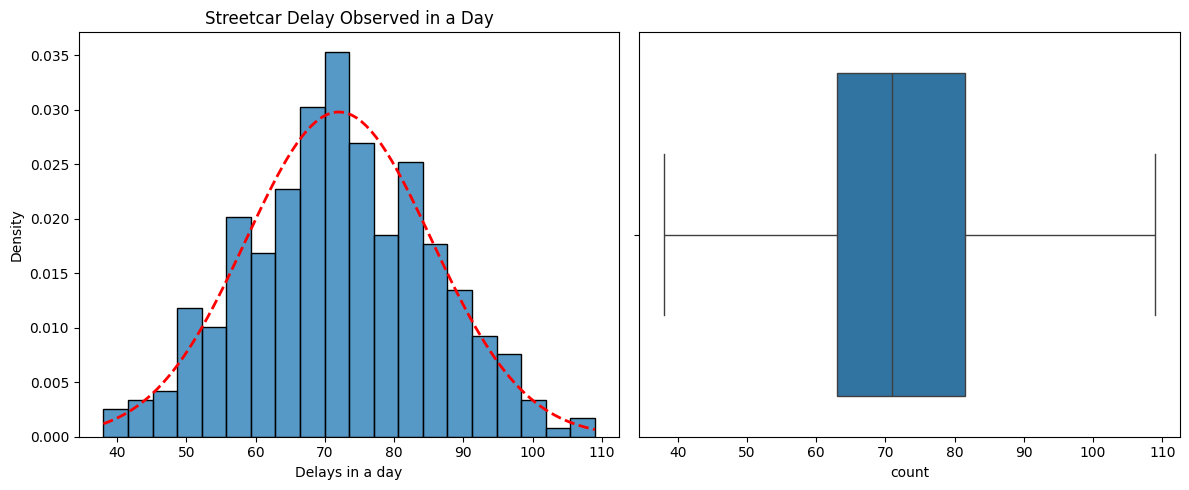

In [14]:
sw_date_counts = subway['Date'].value_counts()
# Fit a normal distribution
mu, sigma = np.mean(sw_date_counts), np.std(sw_date_counts)
x = np.linspace(min(sw_date_counts), max(sw_date_counts), 100)
y = stats.norm.pdf(x, mu, sigma)

# Plot histogram with normal distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of delay counts
sns.histplot(sw_date_counts, ax=ax[0], bins=20, kde=False, stat="density")
ax[0].plot(x, y, color='red', linestyle='dashed', linewidth=2)  # Normal distribution line
ax[0].set_xlabel("Delays in a day")
ax[0].set_ylabel("Density")
ax[0].set_title("Streetcar Delay Observed in a Day")

# Boxplot
sns.boxplot(x=sw_date_counts, ax=ax[1])

plt.tight_layout()
plt.show()

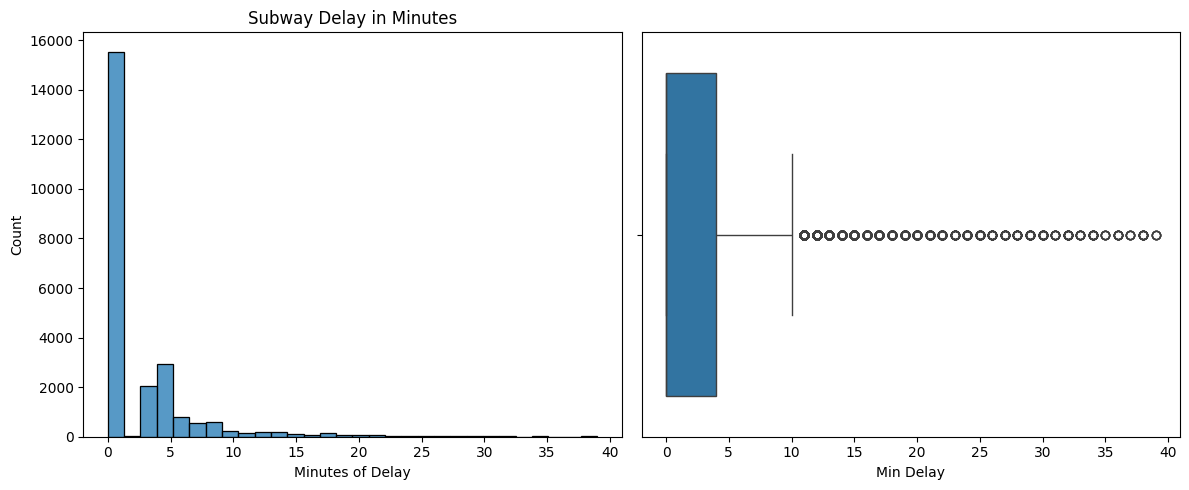

In [15]:
# Filter out extreme delays (keeping <100 minutes)
filtered_delays = subway[subway['Min Delay'] < 40]['Min Delay']

# Plot histogram and boxplot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of delay times
sns.histplot(filtered_delays, ax=ax[0], bins=30, kde=False, stat="count")
ax[0].set_xlabel("Minutes of Delay")
ax[0].set_ylabel("Count")
ax[0].set_title("Subway Delay in Minutes")

# Boxplot
sns.boxplot(x=filtered_delays, ax=ax[1])

plt.tight_layout()
plt.show()

C:\Users\Elowe\AppData\Local\Temp\ipykernel_43804\4145113756.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_filtered_delays = subway[subway['Min Delay'] > 1][subway['Min Delay'] < 100]['Min Delay']


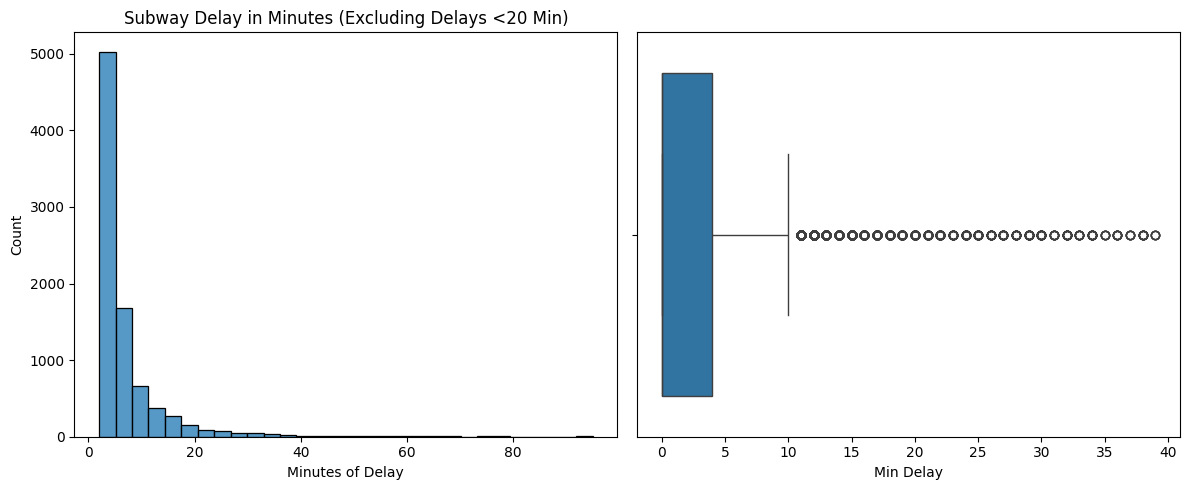

In [16]:
filtered_filtered_delays = subway[subway['Min Delay'] > 1][subway['Min Delay'] < 100]['Min Delay']
# Plot histogram and boxplot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of delay times
sns.histplot(filtered_filtered_delays, ax=ax[0], bins=30, kde=False, stat="count")
ax[0].set_xlabel("Minutes of Delay")
ax[0].set_ylabel("Count")
ax[0].set_title("Subway Delay in Minutes (Excluding Delays <20 Min)")

# Boxplot
sns.boxplot(x=filtered_delays, ax=ax[1])

plt.tight_layout()
plt.show()

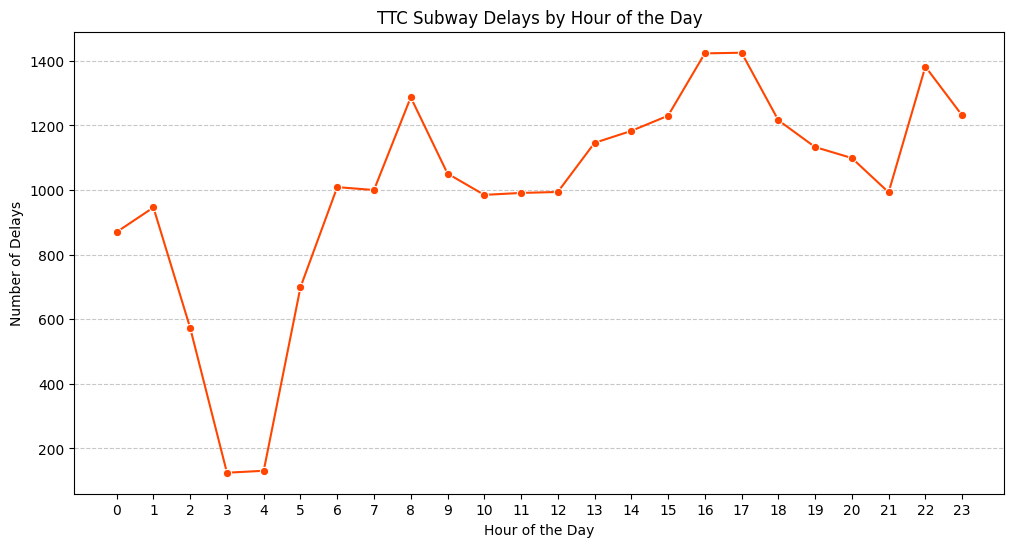

In [17]:
# Count occurrences of delays for each hour
hourly_delays = subway['Hour'].value_counts().sort_index()

# Plot

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_delays.index, y=hourly_delays.values, marker="o", color="orangered")

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Delays")
plt.title("TTC Subway Delays by Hour of the Day")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

<Figure size 1200x600 with 0 Axes>

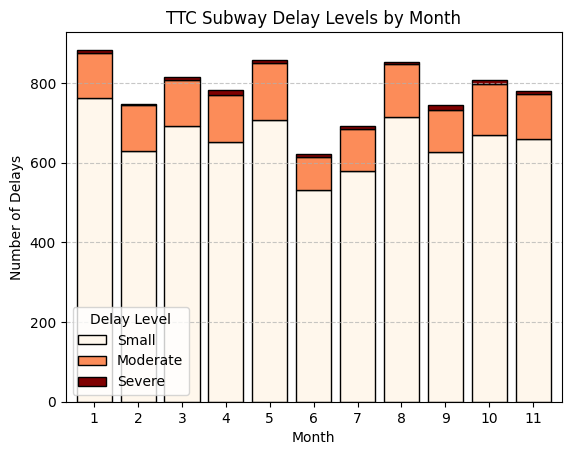

In [18]:
# Group by Month and Delay Level
monthly_delays = subway.groupby(["Month", "Delay Level"], observed=True).size().unstack()

# Plot
plt.figure(figsize=(12, 6))
monthly_delays.plot(kind="bar", stacked=True, colormap="OrRd", edgecolor="black", width=0.8)

plt.xlabel("Month")
plt.ylabel("Number of Delays")
plt.title("TTC Subway Delay Levels by Month")
plt.xticks(ticks=range(11), labels=range(1, 12), rotation=0)  # Ensure months are 1-11 since December is not recorded
plt.legend(title="Delay Level")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

<Figure size 1200x600 with 0 Axes>

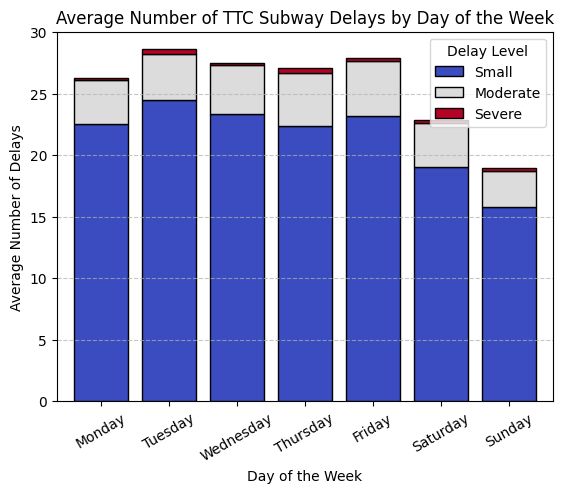

In [19]:
# Define an ordered list of days for proper sorting
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Count the number of delays for each day and delay level
daily_counts = subway.groupby(["Day", "Delay Level"], observed=True).size()

# Find the number of occurrences of each day of the week
unique_day_counts = subway.groupby("Day")["Date"].nunique()

# Normalize by dividing the count of delays by the number of days
avg_daily_counts = daily_counts / unique_day_counts

# Unstack the results to get Delay Levels as columns
avg_daily_counts = avg_daily_counts.unstack()

# Sort the days in the correct order (if needed)
avg_daily_counts = avg_daily_counts.reindex(day_order)

# Plot
plt.figure(figsize=(12, 6))
avg_daily_counts.plot(kind="bar", stacked=True, colormap="coolwarm", edgecolor="black", width=0.8)

plt.xlabel("Day of the Week")
plt.ylabel("Average Number of Delays")
plt.title("Average Number of TTC Subway Delays by Day of the Week")
plt.xticks(rotation=30)
plt.legend(title="Delay Level")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [22]:
import geopandas as gpd
import contextily as ctx

ttc_lines = gpd.read_file("TTC_SUBWAY_LINES_WGS84.shp")
toronto_map = gpd.read_file("Neighbourhoods - 4326.shp")

In [23]:
# Load subway station coordinates
stations_df = pd.read_csv("toronto_subway_stations.csv")
merged_df = subway.merge(stations_df, on="Station", how="left")

In [24]:
# Group by station and calculate average delay
avg_delays = merged_df.groupby(["Station", "lat", "long"])["Min Delay"].mean().reset_index()

# Rename column for clarity
avg_delays.rename(columns={"Min Delay": "Avg_Min_Delay"}, inplace=True)

# Show the processed dataset
print(avg_delays.head())

       Station        lat       long  Avg_Min_Delay
0     Bathurst  43.666416 -79.411309       1.364238
1          Bay  43.670185 -79.390269       2.383085
2      Bayview  43.766799 -79.387379       3.736364
3    Bessarion  43.769060 -79.375884       1.803279
4  Bloor-Yonge  43.670786 -79.385687       1.968535


In [26]:
import folium
from folium.plugins import HeatMap

# Create base map centered on Toronto
toronto_map = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles="cartoDB dark_matter")

# Add delay heatmap layer
heat_data = avg_delays[["lat", "long", "Avg_Min_Delay"]].values.tolist()
HeatMap(heat_data, radius=12).add_to(toronto_map)

# Display map
toronto_map.save("ttc_delay_map.html")  # Saves interactive map

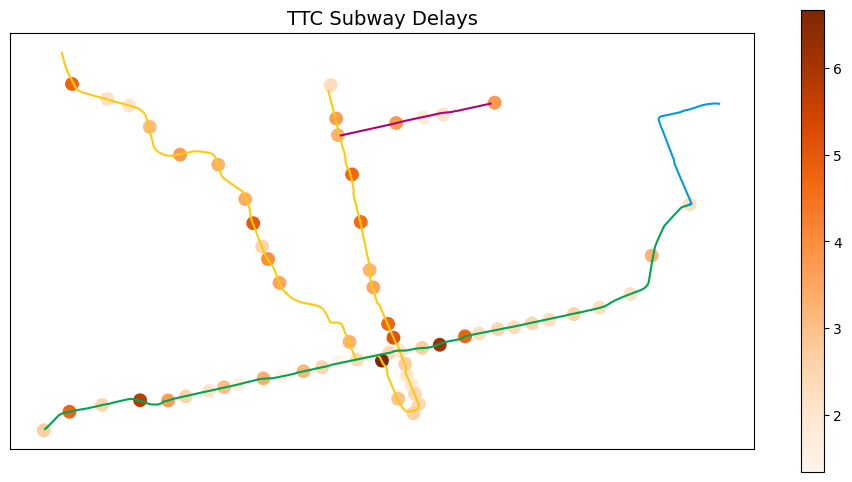

In [27]:
# Convert avg_delays to GeoDataFrame
gdf = gpd.GeoDataFrame(avg_delays, geometry=gpd.points_from_xy(avg_delays.long, avg_delays.lat))

route_colors = {
    1: "#FECA0A",  # Yellow
    2: "#00A54F",  # Green
    3: "#009BDE",  # Blue
    4: "#B30174"  # Purple
}

ttc_lines['Line Color'] = ttc_lines['RID'].map(route_colors)

# Plot TTC subway lines
fig, ax = plt.subplots(figsize=(12, 12))
ttc_lines.plot(ax=ax, color=ttc_lines['Line Color'], linewidth=1.5)  # Subway lines

# Plot delays as a heatmap effect
gdf.plot(ax=ax, column="Avg_Min_Delay", cmap="Oranges", legend=True, markersize=80, legend_kwds={"shrink":.5})
ax.set_xticks([]) 
ax.set_yticks([])

plt.title("TTC Subway Delays", fontsize=14)
plt.show()

In [28]:
ttc_lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    4 non-null      float64 
 1   ROUTE_NAME  4 non-null      object  
 2   RID         4 non-null      int64   
 3   geometry    4 non-null      geometry
 4   Line Color  4 non-null      object  
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 292.0+ bytes


# Part 3: Predict Delays

In [33]:
subway

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Year,Month,ExactDate,Hour,Delay Level,Incident
0,2024-01-01,1900-01-01 02:00:00,Monday,Sheppard,MUI,0,0,N,YU,5491,2024,1,1,2,NaN,Injured or ill Customer (On Train) - Transported
1,2024-01-01,1900-01-01 02:00:00,Monday,Dundas,MUIS,0,0,N,YU,0,2024,1,1,2,NaN,Injured or ill Customer (In Station) - Transpo...
2,2024-01-01,1900-01-01 02:08:00,Monday,Dundas,MUPAA,4,10,N,YU,6051,2024,1,1,2,Small,Passenger Assistance Alarm Activated - No Trou...
3,2024-01-01,1900-01-01 02:13:00,Monday,Kennedy,PUTDN,10,16,E,BD,5284,2024,1,1,2,Small,Unknown
4,2024-01-01,1900-01-01 02:22:00,Monday,Bloor-Yonge,MUPAA,4,10,N,YU,5986,2024,1,1,2,Small,Passenger Assistance Alarm Activated - No Trou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24117,2024-11-30,1900-01-01 10:30:00,Saturday,Islington,TUSC,0,0,W,SHP,5067,2024,11,30,10,NaN,Operator Overspeeding
24118,2024-11-30,1900-01-01 15:26:00,Saturday,Sheppard-Yonge,MUIRS,0,0,NaN,SHP,0,2024,11,30,15,NaN,Injured or ill Customer (In Station) - Medical...
24119,2024-11-30,1900-01-01 21:19:00,Saturday,Leslie,TUO,7,14,W,SHP,6171,2024,11,30,21,Small,Transportation Department - Other
24120,2024-11-30,1900-01-01 23:59:00,Saturday,Sheppard-Yonge,PUSO,0,0,W,SHP,6181,2024,11,30,23,NaN,S/E/C Department Other


In [34]:
sw=subway.dropna()

In [35]:
sw['Delay Level'].unique()

['Small', 'Moderate', 'Severe']
Categories (3, object): ['Small' < 'Moderate' < 'Severe']

In [55]:
day_map = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}
sw['Day_encoded'] = sw['Day'].map(day_map)
bound_map = {
    'E':0,
    'S':1,
    'W':2,
    'N':3,
    'B':4
}
sw['Bound_encoded'] = sw['Bound'].map(bound_map)
level_map = {
    'Small':0,
    "Moderate":1,
    'Severe':3
}
sw['level_encoded'] = sw['Delay Level'].map(level_map)

line_map = {
    'YU':0,
    "BD":1,
    'SHP':2
}
sw['line_encoded'] = sw['Line'].map(line_map)

station_counts = sw['Station'].value_counts()
top_10_stations = station_counts.head(10).index 
sw['most_delayed_station'] = sw['Station'].apply(lambda x: 1 if x in top_10_stations else 0)

incident_avg_delay = sw.groupby('Incident')['Min Delay'].mean()

max_delay = incident_avg_delay.max()
incident_weights = incident_avg_delay / max_delay  

incident_weights_dict = incident_weights.to_dict()

sw['incident_weight'] = sw['Incident'].apply(lambda x: incident_weights_dict.get(x, 1))
sw['level_encoded']=sw['level_encoded'].astype(int)

C:\Users\Elowe\AppData\Local\Temp\ipykernel_43804\1941125779.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sw['Day_encoded'] = sw['Day'].map(day_map)
C:\Users\Elowe\AppData\Local\Temp\ipykernel_43804\1941125779.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sw['Bound_encoded'] = sw['Bound'].map(bound_map)
C:\Users\Elowe\AppData\Local\Temp\ipykernel_43804\1941125779.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [56]:
X1 = sw.drop(['Min Delay','Day','Date','Month','Time','Bound','Vehicle','Delay Level','Code','Incident','Station','Line','Year'], axis=1) 
y1 = sw['Min Delay']

In [57]:
X1

,Min Gap,ExactDate,Hour,Day_encoded,Bound_encoded,level_encoded,most_delayed_station,incident_weight,line_encoded
2,10,1,2,0,3,0,0,0.023384,0
3,16,1,2,0,0,0,1,0.085999,1
4,10,1,2,0,3,0,1,0.023384,0
5,9,1,2,0,3,0,1,0.023384,0
7,13,1,2,0,0,0,0,0.036503,1
...,...,...,...,...,...,...,...,...,...
24103,8,30,22,5,3,0,0,0.023384,0
24107,11,30,22,5,3,0,1,0.041249,0
24111,12,30,0,5,0,0,1,0.034951,1
24114,11,30,0,5,1,0,0,0.056673,0


<Figure size 1200x800 with 0 Axes>

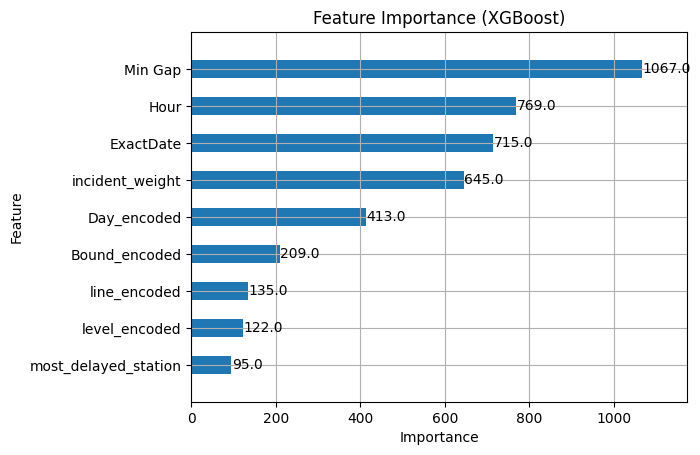

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
model1 = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_test)
mae = mean_absolute_error(y1_test, y1_pred)
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))
plt.figure(figsize=(12, 8))
xgb.plot_importance(model1, 
                    importance_type='weight',  # Can also use 'gain' or 'cover'
                    max_num_features=20,  # Limit to top 20 features (optional)
                    height=0.5,  # Height of the bars
                    title="Feature Importance (XGBoost)", 
                    xlabel="Importance", 
                    ylabel="Feature")
plt.show()

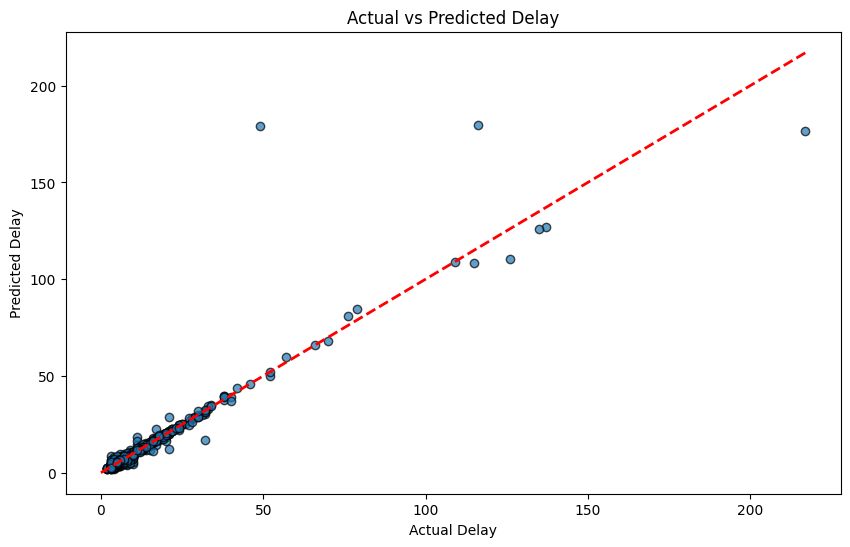

In [60]:
# Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y1_test, y1_pred, alpha=0.7, edgecolors='k')
plt.plot([0, max(y1_test)], [0, max(y1_test)], 'r--', lw=2)  # Line of perfect prediction
plt.xlabel("Actual Delay")
plt.ylabel("Predicted Delay")
plt.title("Actual vs Predicted Delay")
plt.show()

<Figure size 1200x600 with 0 Axes>

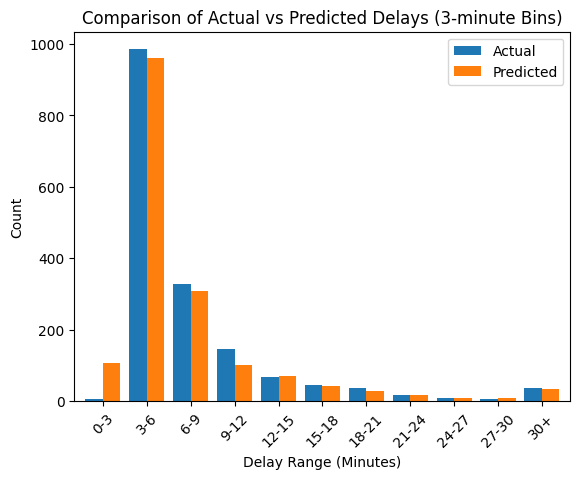

In [61]:
bins = list(range(0, 33, 3))  # [0, 3, 6, ..., 30]
bins.append(np.inf)  # To include values above 30 in the last bin
labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24', '24-27', '27-30', '30+']

# Bin the actual delays and predicted delays
actual_binned = pd.cut(y1_test, bins=bins, labels=labels, right=False)
predicted_binned = pd.cut(y1_pred, bins=bins, labels=labels, right=False)

# Count how many predictions fall into each bin for both actual and predicted delays
actual_counts = actual_binned.value_counts().sort_index()
predicted_counts = predicted_binned.value_counts().sort_index()

# Create a DataFrame to compare actual and predicted counts
comparison_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
})

# Plot the comparison
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', width=0.8, color=['#1f77b4', '#ff7f0e'])
plt.title("Comparison of Actual vs Predicted Delays (3-minute Bins)")
plt.xlabel("Delay Range (Minutes)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()